# Predicting the Winner of a League of Legends Game
#### December 9th, 2020

## Define Problem
#### Problem definition:
League of Legends (LoL) has a highly developed competitive scene, and teams competing at high levels often look at various statistics to measure their in-game success. Teams would like to understand which parameters have high influence on the outcome of games, so they can analyze and improve their strategy. 

#### Topic description:
LoL is a Multiplayer Online Battle Arena (MOBA) game, where each player controls a character with a unique set of abilities. Every LoL ranked game has 2 teams, red and blue, with 5 players on each team. These teams fight for gold, experience and objectives, with each team having the end goal of destroying the other’s base. LoL has the biggest competitive e-sports scene in the world, meaning that teams build complex strategies and seek to find efficient ways to outplay the opponent. 

#### Research Question:
Based on various statistics involved in a LoL game, can we accurately and consistently predict a winner based on the first 10 minutes of a game? Which factors are the most influential in determining the outcome of a LoL game? 


## Data
LoL has an ELO-based ladder system, where players are ranked Iron, Bronze, Silver, Gold, Platinum, Diamond, Master, Grandmaster or Challenger (lowest to highest), with Bronze-Diamond having 4 divisions each. We found a dataset on Kaggle that contains 10,000 very high ELO games (Diamond 1 - Master (top 0.1%)), where players are all similarly ranked. There are 19 features included per team, amounting to 38 features for each game in the data, with an additional 2 features indicating the outcome of the game and the game id (40 columns total). The data records these various features for the first 10 minutes of the game. Games that were too short (< 15 mins) were not included in the data, due to issues related to surrendering. 

Below is the glossary taken from the description of the Kaggle dataset:
#### Glossary
* Warding totem: An item that a player can put on the map to reveal the nearby area. Very useful for map/objectives control.
* Minions: NPC that belong to both teams. They give gold when killed by players.
* Jungle minions: NPC that belong to NO TEAM. They give gold and buffs when killed by players.
* Elite monsters: Monsters with high hp/damage that give a massive bonus (gold, XP, stats) when killed by a team.
* Dragons: Elite monster which gives team bonus when killed. The 4th dragon killed by a team gives a massive stats bonus. The 5th dragon (Elder Dragon) offers a huge advantage to the team.
* Herald: Elite monster which gives stats bonus when killed by the player. It helps to push a lane and destroys structures.
* Towers: Structures you have to destroy to reach the enemy Nexus. They give gold.
* Level: Champion level. Start at 1. Max is 18.

Here is the link to the dataset: https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics.pairwise as pairs
import sklearn.manifold as mani
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import time

table = pd.read_csv("high_diamond_ranked_10min.csv")
table

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,4527873286,1,17,2,1,7,4,5,1,1,...,0,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6
9875,4527797466,1,54,0,0,6,4,8,1,1,...,0,15456,7.0,18367,206,56,-782,-888,20.6,1545.6
9876,4527713716,0,23,1,0,6,7,5,0,0,...,0,18319,7.4,19909,261,60,2416,1877,26.1,1831.9
9877,4527628313,0,14,4,1,2,3,3,1,1,...,0,15298,7.2,18314,247,40,839,1085,24.7,1529.8


## Minor Processing
First, we obtain a normalized version of the data to use for various analysis and visualization techniques.


In [2]:
data = table.iloc[:,2:]
norm = (data - data.mean()) / data.std()
data = pd.concat([norm, table.blueWins], axis=1)
data

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,...,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
0,0.316980,-0.379256,0.990379,0.935254,-0.046924,1.071441,-0.879186,-0.753188,-0.481108,-0.210428,...,0.052290,-0.410454,-0.763176,-0.928694,0.367666,-0.256215,-0.013341,-0.928694,0.052290,0
1,-0.570963,-0.839026,-1.009612,-0.393196,-0.387777,-0.404748,-0.879186,-0.753188,-0.481108,-0.210428,...,0.758580,-0.410454,-0.436958,1.033731,0.068500,1.191194,0.593312,1.033731,0.758580,0
2,-0.404474,-1.298797,-1.009612,0.271029,1.657340,-0.650779,0.719467,1.327556,-0.481108,-0.210428,...,0.533882,-0.410454,-0.590472,-0.654867,-2.324826,0.483590,0.520410,-0.654867,0.533882,0
3,1.149426,-0.839026,-1.009612,-0.725309,-0.387777,-0.404748,0.719467,-0.753188,2.078325,-0.210428,...,-0.007406,0.244615,-0.000609,0.805542,-0.430109,0.544323,-0.013862,0.805542,-0.007406,0
4,2.925312,0.540285,-1.009612,-0.061084,-0.046924,-0.158716,-0.879186,-0.753188,-0.481108,-0.210428,...,0.613700,0.244615,0.293070,0.349164,1.564329,0.415112,-0.137276,0.349164,0.613700,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,-0.293481,-0.379256,0.990379,0.271029,-0.728629,-0.404748,0.719467,1.327556,-0.481108,-0.210428,...,-0.833759,-0.410454,-1.221216,0.531716,-1.726495,-1.020884,-1.303197,0.531716,-0.833759,1
9875,1.759887,-1.298797,-1.009612,-0.061084,-0.728629,0.333347,0.719467,1.327556,-0.481108,-0.210428,...,-0.692903,0.244615,0.338124,-0.517954,0.467388,-0.312873,-0.479918,-0.517954,-0.692903,1
9876,0.039497,-0.839026,-1.009612,-0.061084,0.293929,-0.404748,-0.879186,-0.753188,-0.481108,-0.210428,...,1.227428,1.554752,1.624642,1.992125,0.866276,0.990652,0.959908,1.992125,1.227428,0
9877,-0.459970,0.540285,0.990379,-1.389534,-1.069482,-0.896811,0.719467,1.327556,-0.481108,-0.210428,...,-0.798880,0.899684,0.293905,1.353196,-1.128163,0.347857,0.547488,1.353196,-0.798880,0


## Exploratory Analysis and Visualization
First, to gain a general understanding about the variance within the data, we perform Principal Component Analysis (PCA). Since we wanted to also represent this visually, we chose to run PCA with two components, for straightforward plotting. From the explained variance ratio, we can see that these two components explain ~45% of the variance within the data. 

Since we're interested in predicting a game winner from the data features, we visualize this data with respect to the target (the game winner). Looking at the PCA plot, there appear to be two distinct "sides" to the data, which is an indicator that we can likely have success with our predictive analysis. That being said, there is considerable overlap between the two, so the data is by no means perfectly split. 

Also note that the data contains roughly the same amount of blue wins as red wins, since the ratio of blue wins to red wins is approximately equal to 1. Balance in the data is great for predictive analytics.

### Process
To perform PCA, we generate a model using sklearn's PCA module and fit it to our dataset. We'd like to make the visualization inuitive, so we replace the 0s and 1s in the target column with their respective string "meanings": Red Wins or Blue Wins. To plot blue wins in blue and red wins in red, we run through a for loop, which plots the two groups of data points separately. To show overlap in the data, we turn the alpha value down. 

Ratio of blue wins to red wins: 0.9961608405738533
Explained variance for principal components 1 and 2, respectively: [0.32836652 0.12140505]


<Figure size 432x288 with 0 Axes>

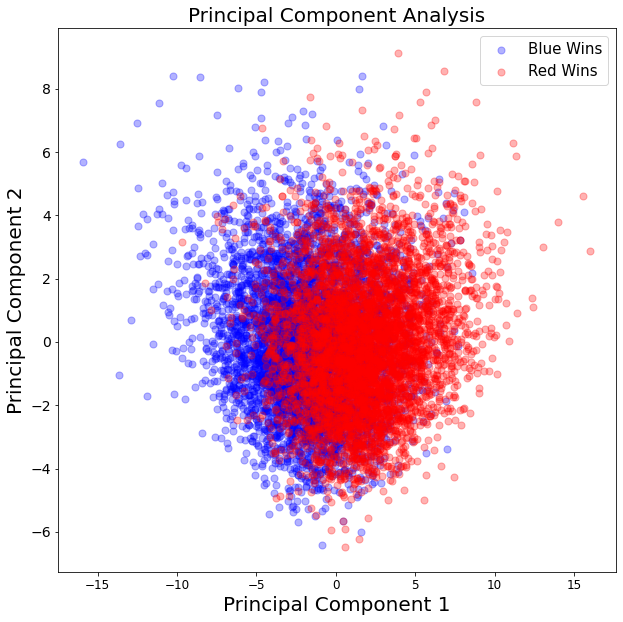

In [3]:
pca_model = PCA(n_components=2)
winsPCA = pca_model.fit_transform(data.iloc[:,:-1])
winsPCA_DF = pd.DataFrame(winsPCA, columns=['PC1', 'PC2'])
data['blueWins'].replace(0, 'Red Wins', inplace=True)
data['blueWins'].replace(1, 'Blue Wins', inplace=True)
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel("Principal Component 1", fontsize=20)
plt.ylabel("Principal Component 2", fontsize=20)
plt.title("Principal Component Analysis", fontsize=20)

targets=["Blue Wins", "Red Wins"]
colors=['b', 'r']

for (target, color) in zip(targets, colors):
    indicesToKeep = (data['blueWins'] == target)
    plt.scatter(winsPCA_DF.loc[indicesToKeep, 'PC1'], winsPCA_DF.loc[indicesToKeep, 'PC2'], c=color, s=50, alpha=0.3)
    
plt.legend(targets, prop={'size':15})
print("Ratio of blue wins to red wins: "+str(len(data[data.blueWins == "Blue Wins"]) / len(data[data.blueWins == "Red Wins"])))
explainedVar = pca_model.explained_variance_ratio_
print("Explained variance for principal components 1 and 2, respectively: " + str(explainedVar))

## Exploratory Visualization
To get an overview of the feature's relationships to the game outcome, we make use of a parallel coordinates plot. The most striking relationships are those which are large-scale and polarizing; that is, those for which red wins and blue wins tend to opposite sides. 

In particular, we see that "towers destroyed" seems to be a very polarizing feature, which makes sense in the context of the game. We see that the "towers destroyed" features are very granular, which is also expected, since there aren't many possible values for number of towers destroyed. While other features don't peak as high as "towers destroyed", other polarizing features include those related to gold and experience difference between the two teams. 

While the plot does a good job of highlighting some polarizing relationships, it doesn't necessarily say much about the actual correlation values between individual features and the game outcome. We explore that next. 

### Process
Generating this visualization was very straightforward. We simply use matplotlib and pandas to plot and set some features, like the legend, title, and xticks. 

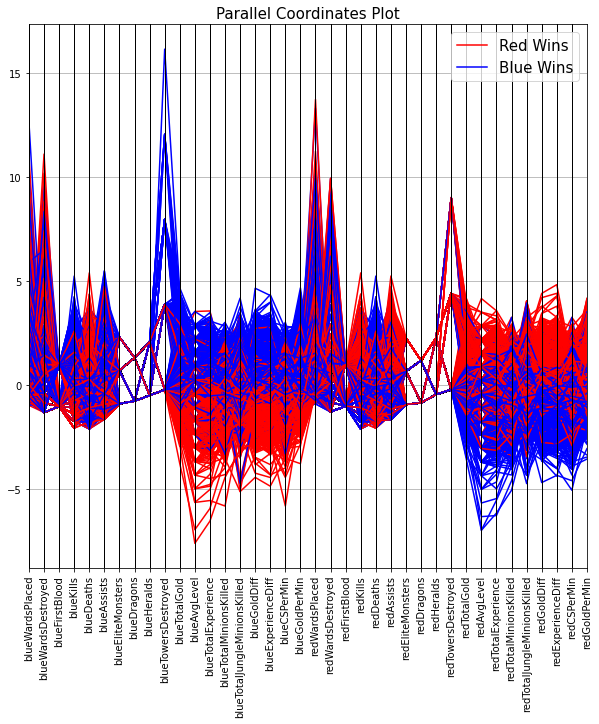

In [4]:
plt.figure(figsize=(10,10))
parcoords = pd.plotting.parallel_coordinates(data, 'blueWins', color=('r','b'))
plt.xticks(rotation=90)
plt.legend(loc=1, prop={'size':15})
plt.title("Parallel Coordinates Plot", fontsize=15)
plt.show()

## Analysis and Visualization
We're interested in looking at the F-Statistic between each feature and the game outcome, so we compute the F-Statistics and plot them on a bar graph. Large magnitude values indicate low independence between the feature and the game outcome. As such, the features yielding the highest F-Statistic will be our best predictors for the game outcome. 

Since many of the features mirror each other (i.e blue kills and red deaths), plotting all of them together caused granularity without adding any information. So, to remove some of the symmetry and highlight individual dependencies, we chose to only plot the features that gave information about the blue team (i.e blue gold difference, blue experience difference). 

From this second graph, it's most evident that features having to do with gold and experience differences between the two teams were the best predictors for the game outcome. Interestingly enough, even though "towers destroyed" was particularly note-worthy in the parallel coordinates plot, it's not a very good predictor. Also, note that ward-related features are the worst predictors, since both teams are actively warding, regardless of which team has the advantage. 

### Process
First, we convert the string values for the target back to quantitative form. We then calculate the ANOVA F-Statistics for each feature with the game outcome using SKLearn's f_classif(). Once we have the column of scores, we associate it with our feature names through a zip operation. Then, it's just a matter of plotting, which is really simple in this case. We chose to use a bar graph since the data is 1 dimensional. 

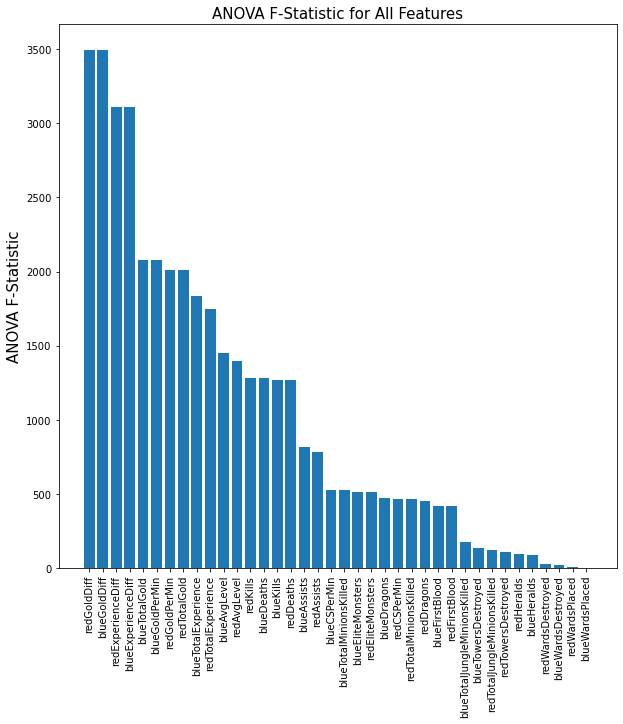

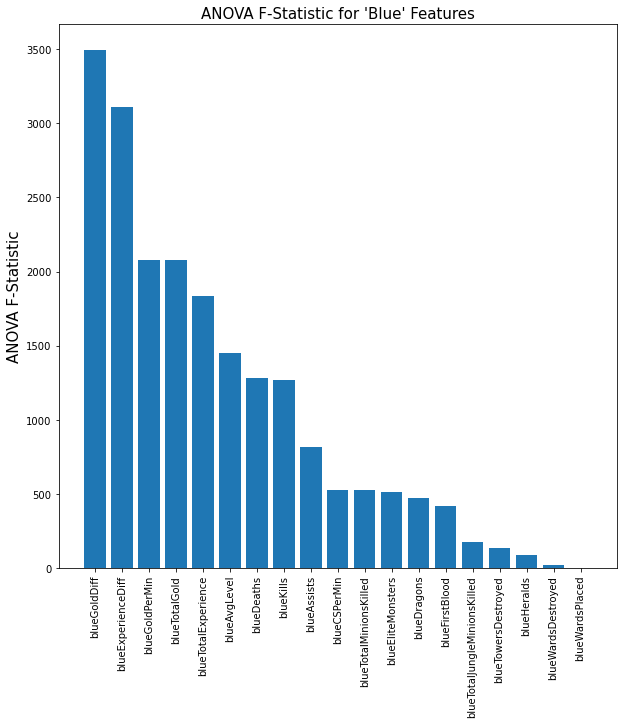

In [5]:
quant = data.replace('Blue Wins', 1)
quant = quant.replace('Red Wins', 0)
bWins = quant['blueWins']

anova = f_classif(quant.drop('blueWins', axis=1), bWins)
fscores = anova[0]
selectors = zip(fscores, quant.drop('blueWins', axis=1).columns)
selectorsDF = pd.DataFrame(selectors, columns=['fstat','features'])
selectorsDF.sort_values('fstat', ascending=False, inplace=True)
plt.figure(figsize=(10,10))
plt.bar(x=selectorsDF.features, height=selectorsDF.fstat)
plt.xticks(rotation=90)
plt.title('ANOVA F-Statistic for All Features', fontsize=15)
plt.ylabel('ANOVA F-Statistic', fontsize=15)
plt.show()

anova = f_classif(quant.drop('blueWins', axis=1).iloc[:,0:19], bWins)
fscores = anova[0]
selectors = zip(fscores, quant.drop('blueWins', axis=1).iloc[:,0:19].columns)
selectorsDF = pd.DataFrame(selectors, columns=['fstat','features'])
selectorsDF.sort_values('fstat', ascending=False, inplace=True)
plt.figure(figsize=(10,10))
plt.bar(x=selectorsDF.features, height=selectorsDF.fstat)
plt.xticks(rotation=90)
plt.title('ANOVA F-Statistic for \'Blue\' Features', fontsize=15)
plt.ylabel('ANOVA F-Statistic', fontsize=15)
plt.show()

## Predictive Analytics
There's a wide variety of classification tools available to us, some of which are better than others for our purposes. So, we pick 5 such tools to experiment with to determine which ones are most effective at predicting the outcome of a LoL game based on a number of features. First, we begin by testing out these classifiers using all of the features available to us in the dataset. 

The main two things we'd like to get out of these classifiers are precision and speed. Since the classifiers don't always yield the same results, we use cross-validation in order to test the model on all of our data, minimizing bias. 

The 5 classifiers we used were Logistic Regression, k-Nearest Neighbors, Random Forest, Naive Bayes and Support Vector Machine (with RBF kernel). From the plot, we can see that all of the classifiers had similar f1 scores, but k-Nearest Neighbors seems to lose out by a margin of ~0.2 when compared to the other 4 methods. In terms of runtime, Logistic Regression and Naive Bayes saw the best results by far.

Combining the metrics, Logistic Regression and Naive Bayes seem to be the best choices. They differ slightly from each other in both runtime and f1 score, but are both substantially faster than any of the other 3 methods, and are among the most accurate. Logistic Regression is the overall winner, since it's most accurate and very fast.  

Overall, the f1 scores indicate that we can predict the game winner correctly ~72% of the time, which is not bad. In the next section, we will employ feature selection to further enhance our predictive analysis.

### Process
To build the analysis, we first create lists for f1 scores, classifier method names, and runtimes. Then, we performed cross-validation and added the averages for f1 scores and runtimes to our lists, as well as the classifier method names. Finally, we zipped these lists together and used that to create a DataFrame for easy data storage and plotting. We plotted the points one by one, and manually assigned each one a unique color. 

We experimented with several testing data sizes, and found that the 20% size produced good results without being too large of a subset of our overall data.

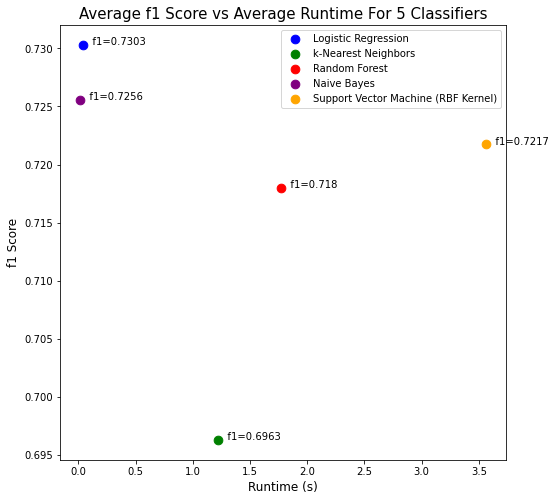

In [6]:
fones = []
times = []
methods = []
    
logReg = LogisticRegression()
start = time.time()
fones.append(cross_val_score(logReg, quant.drop('blueWins', axis=1), bWins, cv=5, scoring='f1').mean())
end = time.time()
times.append((end-start)/5)
methods.append("Logistic Regression")

knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
start = time.time()
fones.append(cross_val_score(knn, quant.drop('blueWins', axis=1), bWins, cv=5, scoring='f1').mean())
end = time.time()
times.append((end-start)/5)
methods.append("k-Nearest Neighbors")

rfc = RandomForestClassifier(n_estimators=100)
start = time.time()
fones.append(cross_val_score(rfc, quant.drop('blueWins', axis=1), bWins, cv=5, scoring='f1').mean())
end = time.time()
times.append((end-start)/5)
methods.append("Random Forest")

nb = GaussianNB()
start = time.time()
fones.append(cross_val_score(nb, quant.drop('blueWins', axis=1), bWins, cv=5, scoring='f1').mean())
end = time.time()
times.append((end-start)/5)
methods.append("Naive Bayes")

svclassifier = SVC(kernel="rbf")
start = time.time()
fones.append(cross_val_score(svclassifier, quant.drop('blueWins', axis=1), bWins, cv=5, scoring='f1').mean())
end = time.time()
times.append((end-start)/5)
methods.append("Support Vector Machine (RBF Kernel)")

methodScores = zip(fones, methods, times)
methodScoresDF = pd.DataFrame(methodScores, columns=['fOne', 'classifier', 'runtime'])

fig, axs = plt.subplots(figsize=(8,8))
colorList = ["blue","green","red","purple","orange"]
for i in range(0,5):
    stext = "   f1=" + str(round(methodScoresDF.iloc[i,0],4))
    axs.scatter(x=methodScoresDF.iloc[i,2], y=methodScoresDF.iloc[i,0], color=colorList[i], s=75)
    axs.text(methodScoresDF.iloc[i,2], methodScoresDF.iloc[i,0], stext)
plt.legend(methodScoresDF.classifier)
axs.set_xlabel('Runtime (s)', fontsize=12)
axs.set_ylabel('f1 Score', fontsize=12)
axs.set_title('Average f1 Score vs Average Runtime For 5 Classifiers', fontsize=15)
plt.show()

## Predictive Analytics
Our goal here is to analyze how the classifiers behave with subsets of the features as predictors. The best predictors were determined according to their ANOVA F-Statistic in relation to the game outcome, as displayed in the bar graph above. Having a smaller set of predictors will avoid overfitting and could improve performance, so we experimented with 2, 4, 6 and 8 predictors to see how the classifiers performed. 

From the graphs, we see that Logistic Regression maintains its spot as the most consistently fast and accurate classifier. There are very negligible differences in its f1 score across the board, including its use with all of the available predictors, above. 

The two most notable changes are seen in the SVM and Naive Bayes. The SVM classifier becomes a viable option - its f1-score rivals that of Logistic Regression, and its performance improves substantially with low predictor counts. Naive Bayes, on the other hand, sees a substantial drop in accuracy and practically no change in performance. 

While Random Forest and k-Nearest Neighbors see performance improvements, they continue to fall short in terms of accuracy. They see improvement in accuracy as the number of predictors increases, but they aren't able to rival Logistic Regression. 

### Process
The predictors are selected using SelectKBest and passing in the f_classif function, which picks predictors based on their F-Statistics in relation to the target. This rest of this process mimics that of the cell above, except it's enclosed in a loop in order to test several quantities of predictors.

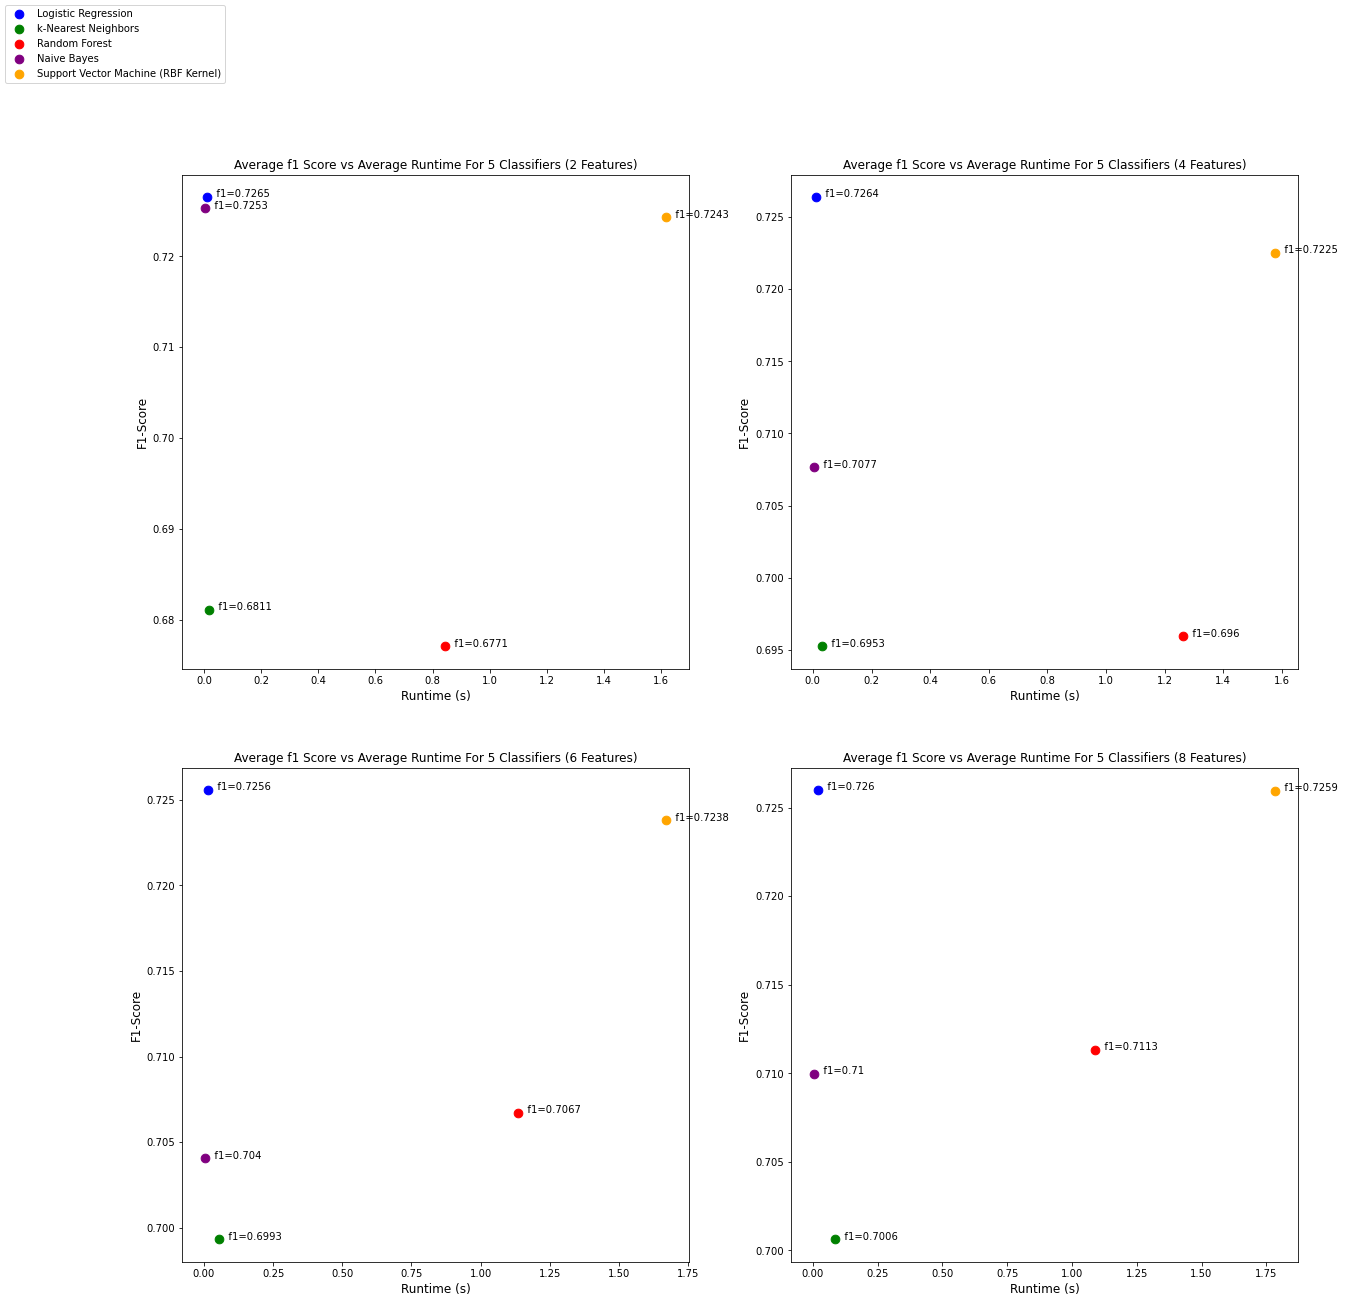

In [7]:
fig, axs = plt.subplots(2,2, figsize=(20,20))
colorList = ["blue","green","red","purple","orange"]
jj = 0

for count in range(2,9,2):
    selector = SelectKBest(f_classif, k=count)
    X_new = selector.fit_transform(quant.drop('blueWins', axis=1).iloc[:,0:19], bWins)
    
    fones = []
    times = []
    methods = []
    
    logReg = LogisticRegression()
    start = time.time()
    fones.append(cross_val_score(logReg, X_new, bWins, cv=5, scoring='f1').mean())
    end = time.time()
    times.append((end-start)/5)
    methods.append("Logistic Regression")

    knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
    start = time.time()
    fones.append(cross_val_score(knn, X_new, bWins, cv=5, scoring='f1').mean())
    end = time.time()
    times.append((end-start)/5)
    methods.append("k-Nearest Neighbors")

    rfc = RandomForestClassifier(n_estimators=100)
    start = time.time()
    fones.append(cross_val_score(rfc, X_new, bWins, cv=5, scoring='f1').mean())
    end = time.time()
    times.append((end-start)/5)
    methods.append("Random Forest")

    nb = GaussianNB()
    start = time.time()
    fones.append(cross_val_score(nb, X_new, bWins, cv=5, scoring='f1').mean())
    end = time.time()
    times.append((end-start)/5)
    methods.append("Naive Bayes")

    svclassifier = SVC(kernel="rbf")
    start = time.time()
    fones.append(cross_val_score(svclassifier, X_new, bWins, cv=5, scoring='f1').mean())
    end = time.time()
    times.append((end-start)/5)
    methods.append("Support Vector Machine (RBF Kernel)")

    methodScores = zip(fones, methods, times)
    methodScoresDF = pd.DataFrame(methodScores, columns=['fOne', 'classifier', 'runtime'])
    
    for i in range(0,5):
        stext = "   f1=" + str(round(methodScoresDF.iloc[i,0],4))
        if (jj > 1):
            axs[1][jj-2].scatter(x=methodScoresDF.iloc[i,2], y=methodScoresDF.iloc[i,0], color=colorList[i], s=75)
            axs[1][jj-2].text(methodScoresDF.iloc[i,2], methodScoresDF.iloc[i,0], stext)
        else:
            axs[0][jj].scatter(x=methodScoresDF.iloc[i,2], y=methodScoresDF.iloc[i,0], color=colorList[i], s=75)
            axs[0][jj].text(methodScoresDF.iloc[i,2], methodScoresDF.iloc[i,0], stext)
    jj+=1

for ii in range(0,2):
    for kk in range(0,2):
        axs[ii][kk].set_xlabel('Runtime (s)', fontsize=12)
        axs[ii][kk].set_ylabel('F1-Score', fontsize=12)

axs[0][0].title.set_text('Average f1 Score vs Average Runtime For 5 Classifiers (2 Features)')
axs[0][1].title.set_text('Average f1 Score vs Average Runtime For 5 Classifiers (4 Features)')
axs[1][0].title.set_text('Average f1 Score vs Average Runtime For 5 Classifiers (6 Features)')
axs[1][1].title.set_text('Average f1 Score vs Average Runtime For 5 Classifiers (8 Features)')
plt.figlegend(methodScoresDF.classifier, loc='upper left')
plt.show()

## Conclusion
Based on data collected in the first 10 minutes of the game, we were able to accurately predict the outcome of a high-ranked LoL game roughly 72% of the time, which is fairly impressive, considering games can last for over an hour. The best predictors turned out to be those related to the gold and experience (xp) differences between the two teams. If a team has a gold and/or xp advantage, they're better equipped to win fights and take objectives, so this isn't surprising. Kills and deaths were also important, but substantially less so than gold/xp differences. The worst predictors turned out to be those related to warding - this makes sense, given that high-ranked players will ward quite consistently, regardless of how well their team is performing. 

To improve this analysis, one might look at using more advanced and customizable classifiers to improve accuracy. Also, this data is limiting in that it only includes the first 10 minutes. If the data included an extra 5 minutes, we would be able to substantially improve the prediction. However, this would also be less interesting, since the point of the analysis is to determine the winner early on in the game. 